In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

#device = torch.device("mps")
device = torch.device("cpu")
print(device, torch.__version__)
#torch.manual_seed(1802)

mat = loadmat("../data/fan_flutter.mat")["x"]
x_sample = torch.from_numpy(mat).float()[:, 4_000:10_000]

reg = 0.01

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

def time_function(f, device, time_list=None, *args, **kwargs):
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    start = time.time()
    result = f(*args, **kwargs)
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    end = time.time()
    elapsed = end-start
    if time_list is None:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    else:
        time_list.append(elapsed)
    return result


cpu 2.7.0


Here, the fastDSTFT is tested

In [2]:
from dstft import fastDSTFT

go
Elapsed time: 0.0297 seconds
Elapsed time: 0.0326 seconds


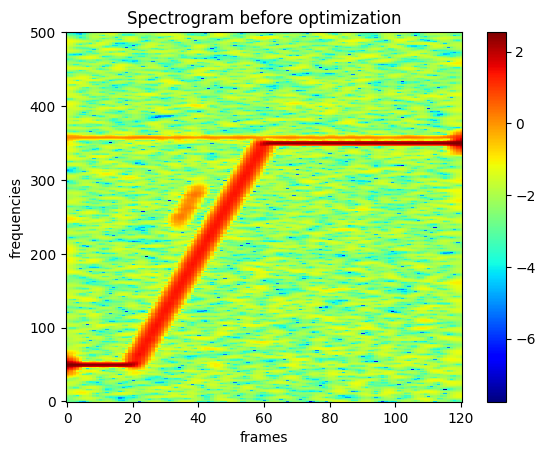

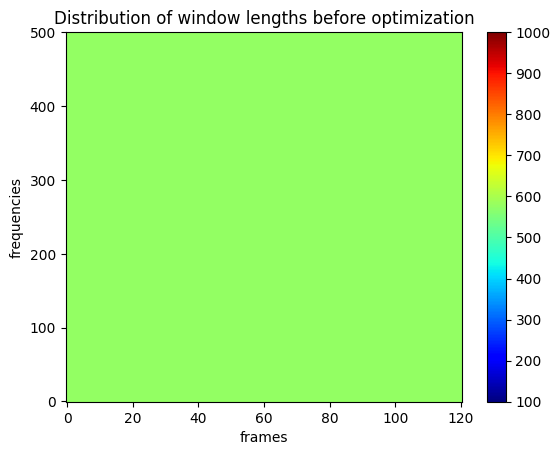

In [35]:
batch_size = 64
x = x_sample.repeat(batch_size, 1).to(device)
#x = torch.randn(1, 6049, device=device)
fastdstft = fastDSTFT(device=device, #device=device, x_sample=x,
                    support=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree = 5,
                    padding = "same"
                    )

#fastdstft = torch.compile(fastdstft, mode="default")  # earlier no difference, now crash
with torch.no_grad():
#    fastdstft.window_lengths.data.uniform_(100, 1000)
#fastdstft.warm_start()
    spec = fastdstft(x)  # making one calculation to avoid overhead
    fastdstft.plot(spec, title="before optimization")
    #fastdstft.plot(spec, title="after warm-start")

False
Time for 10000 passes: 0h 25m 3.39s


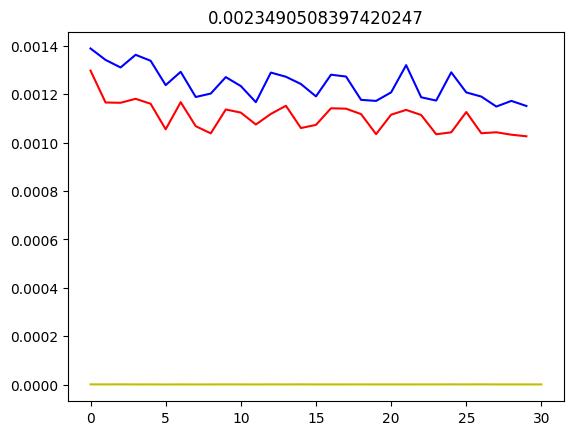

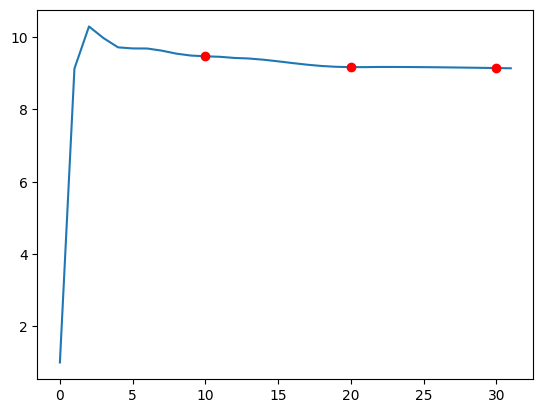

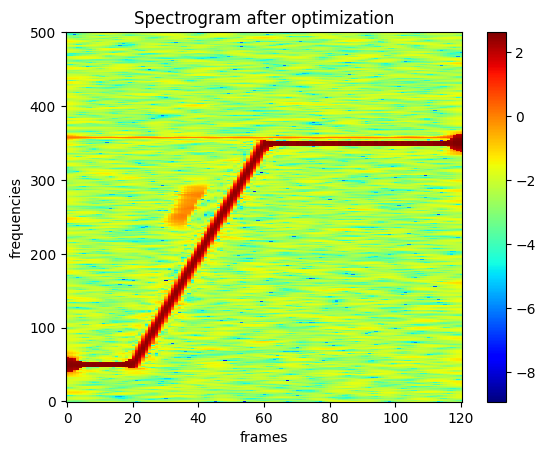

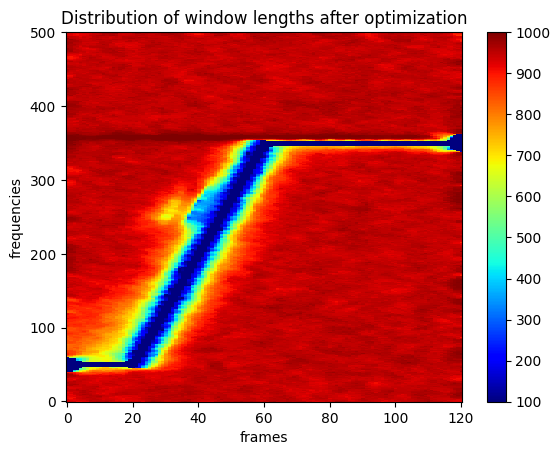

100.0 1000.0 875.9332
finished on epoch 30 with (unregularized) loss 8.946742057800293


'transformed_window_lengths = fastdstft.window_transform(window_lengths)\nprint(transformed_window_lengths.min(), transformed_window_lengths.max())\ntransformed_back_window_lengths = fastdstft.inverse_window_transform(torch.tensor(transformed_window_lengths))\nprint(transformed_back_window_lengths.min(), transformed_back_window_lengths.max())\ntransform_error = torch.tensor(window_lengths) -transformed_back_window_lengths\nprint(transform_error.min(), transform_error.max())'

In [ ]:
initial_lr = 100.0  # 0.01, 10.0, 100.0
params = [{'params': fastdstft.parameters(),'lr': initial_lr}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9)  # 19

fwtimes = []
bwtimes = []
othertimes = []
times = []
#cpu_mem_before = []
#cpu_mem_after = []

mini_loss = lambda x: x.view(-1)[0] * 0 + 1  # lambda x: x.sum() * 0 +1

print(device.type=="mps")

errs = []
#err = entropy_loss(spec) + reg* (fastdstft.get_window_lengths().diff(dim=0)[:, :-1].pow(2) + fastdstft.get_window_lengths().diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
err = mini_loss(spec)
errs.append(err.item())

lr_decrease = []
lr = opt.param_groups[0]['lr']
import torch
import psutil, os
def get_cpu_mem():
    return psutil.Process(os.getpid()).memory_info().rss / 1e6  # in MB
#import gc
#gc.enable()
#gc.disable()
for epoch in range(1_000):  # 1_000
    #opt.zero_grad()
    for param in fastdstft.parameters():
        param.grad = None

    spec = time_function(fastdstft, device, fwtimes, x)

    # this takes 0.002*batch_size on gpu, and 0.0001*batch_size on cpu
    # 0.003 when moving to cpu, although the computation is faster. 
    # i guess this is not a problem in real applications, when this is not the last layer
    err = entropy_loss(spec) + reg* (fastdstft.get_window_lengths().diff(dim=0)[:, :-1].pow(2) + fastdstft.get_window_lengths().diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    #err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    #err = mini_loss(spec)
    errs.append(err.item())
    #with torch.profiler.profile() as prof:

    time_function(err.backward, device, bwtimes)
    opt.step()
    sch.step(err.item())
    
    time_function(fastdstft.put_windows_back, device, othertimes)  # putting window lengths back in the range [100, 1000]

    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < initial_lr/100:
            break

fwtimes = np.array(fwtimes[1:])
#print(fwtimes)
bwtimes = np.array(bwtimes[1:])
othertimes = np.array(othertimes)
def seconds_to_hms(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hours}h {minutes}m {secs:.2f}s"

# Example:
print(f"Time for 10000 passes: {seconds_to_hms(10000*(np.mean(fwtimes)+np.mean(bwtimes)))}")
plt.plot(fwtimes/batch_size, 'r')
plt.plot(bwtimes/batch_size, 'b')
plt.plot(othertimes/batch_size, 'y')

plt.title((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
plt.show()

plt.plot(errs)
plt.plot(lr_decrease, [errs[i] for i in lr_decrease], 'ro')
plt.show()

spec = fastdstft(x)
fastdstft.plot(spec, title="after optimization")

window_lengths = fastdstft.window_lengths.detach().cpu().numpy()
print(window_lengths.min(), window_lengths.max(), window_lengths.mean())
print(f"finished on epoch {epoch} with (unregularized) loss {entropy_loss(spec).item()}")

"""transformed_window_lengths = fastdstft.window_transform(window_lengths)
print(transformed_window_lengths.min(), transformed_window_lengths.max())
transformed_back_window_lengths = fastdstft.inverse_window_transform(torch.tensor(transformed_window_lengths))
print(transformed_back_window_lengths.min(), transformed_back_window_lengths.max())
transform_error = torch.tensor(window_lengths) -transformed_back_window_lengths
print(transform_error.min(), transform_error.max())"""

In [ ]:
adstftdevice = "cpu"  # does not work on gpu
from dstft import ADSTFT
x = x_sample.repeat(batch_size, 1).to(adstftdevice)
dstft = ADSTFT(x_sample, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(adstftdevice)

batch_size = 4
spec, *_ = dstft(x)

fwtimes = []
bwtimes = []

lr_decrease = []
lr = opt.param_groups[0]['lr']
errs = []
params = [{'params': dstft.parameters(),'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19)

for epoch in range(10):
    for param in dstft.parameters():
        param.grad = None

    tic()
    spec, *_ = dstft(x)
    fwtimes.append(toc(print_elapsed=False))

    err = entropy_loss(spec) + reg* (dstft.win_length.diff(dim=0)[:, :-1].pow(2) + dstft.win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())

    tic()
    err.backward()
    bwtimes.append(toc(print_elapsed=False))

    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < 1:
            break
print(np.mean(fwtimes)/batch_size)
print(np.mean(bwtimes)/batch_size)
print((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
# handles batches of up to 8 at 2.4 per sample, fastest at 4 with 1.1
